<a href="https://colab.research.google.com/github/a-forty-two/cylons/blob/master/03_TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Choosing right model or algo 
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

# data from https://community.tableau.com/docs/DOC-1236
!ls

 sample_data  'Sample - Superstore (1).xls'


In [1]:
import pandas as pd
df = pd.read_excel('Sample - Superstore (1).xls')
df.head()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [0]:
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# for production use, we may want to supress the warning
# NEVER for dev-> ALL WARNINGS must be taken into account and fix whatever can be fixed
warnings.filterwarnings("ignore")
# That any code that may throw warning would have inherited the Exceptions and warnings classes
# If some package is throwing warning or exception without using the right channel, then 
# the warning will not be supressed

In [6]:
df.head(2)
# WHENEVER you're into TS analysis -> TIMESTAMPS 
# what if you don't have time stamps but data is arranged in either time-ascending or descending order,
# you can always take a reference timeline -> 1990-2000 
# TIMESTAMP should work like an INDEX and not input dataset 
# TSA -> Univariate and multivariate 
# ONE FEATURE is going to fluctuate w.r.t. TIME 

# TIMESTAMPS -> Order Date and Ship Date 
# Identify all indexes or seemingly indexes and REMOVE THEM -> NEW DF -> don't mutate the old DF
# Identify ALL categorical DATA -> in TSA , categories help us FILTER the data 
# If there categories like COuntry -> Then i could make individual TSA predictions for each country



,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [10]:
# Let's find out all important categorical data or DISCRETE values 
# importance-> usability for filtering 
len(df)
df.Country.value_counts() # Because all values belong to only 1 category!!
df.City.value_counts() # Because TOO MANY values for CITY! here, Analysis is possible 
# for some cities like NYC, LA, Phil because they've enough data points representing them 


New York City    915
Los Angeles      747
Philadelphia     537
San Francisco    510
Seattle          428
                ... 
Danbury            1
Redding            1
Chapel Hill        1
Palatine           1
Bartlett           1
Name: City, Length: 531, dtype: int64

In [14]:
colNames = df.columns 
for i, feature in enumerate(colNames):
  print(colNames[i] + " " + str(len(df[feature].value_counts())))

# FROM OUTPUT below, we can conclude that best variables for categorical filtering were
# 1) Region, 2) Categories, comparitively weaker but still valid-> SUB CATEGORY

Row ID 9994
Order ID 5009
Order Date 1237
Ship Date 1334
Ship Mode 4
Customer ID 793
Customer Name 793
Segment 3
Country 1
City 531
State 49
Postal Code 631
Region 4
Product ID 1862
Category 3
Sub-Category 17
Product Name 1850
Sales 6144
Quantity 14
Discount 12
Profit 7545


In [15]:
df.Category.value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [19]:
data = df.loc[df['Category']=='Furniture']  # LOC-> :,:
#data.head()
print(data['Order Date'].min())
print(data['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


In [20]:
# WHAT IS THE FEATURE that I want to predict against TIME? 
# y= f(x) -> Y is a CONTINUOUS NUMBER that will change as per time 
# 2 kind of numbers -> CONTINUOUS and DISCRETE 
# DISCRETE are categorical features, CONTINUOUS -> numerical real values
# COMPLEX numbers -> Real + imaginary -> break down into 2 separate features and solve separately




,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [21]:
df['Ship Mode'].value_counts()
# If I was a LOGISTICS planner or Biz Analyst, this is the categorical column!


Standard Class    5968
Second Class      1945
First Class       1538
Same Day           543
Name: Ship Mode, dtype: int64

In [22]:
# Best continuous variables to predict AGAINST time 
# Sales and Profit (Sales Biz Analyst)
# Quantity (Logistic Biz Analyst) and Discount (too many 0s)

# For demo, let's proceed with predicting SALES

len(data)
# here we have 4 years of data represented by 2121 rows of dataset
# 365 X 4 -> 1460 unique days! 
# At least some dates have more than 1 order
# maybe some dates may not orders at all! 


# IN TSA we don't expect a GAUSSIAN distribution specially when variables are 
# profit, loss, sales etc. which either increase or decrease! they don't go bell curve

# in prev cases of classification, we would have preferred uniform or gaussian or normal distribution


2121

In [30]:
# ORDER BY and GROUP BY were our go to methods in SQL!
data_grouped = data.groupby('Order Date')
data_grouped = data_grouped['Sales'].sum().reset_index()
data_grouped.tail()
# OUR ASSUMPTIONS WERE CORRECT! 
# At least some dates have more than 1 order
# maybe some dates may not orders at all! 

,Order Date,Sales
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180
888,2017-12-30,323.1360


In [39]:
# HERE PREDICTING DAY by DAY will be a mistake -> real data for this granularity does not exist
# Weekly or monthly prediction 
# Temp this week will be around 22
# M-> 22, T-> 21, W->33, .... Sun-> 21 
# Between the two, the weekly prediction have lesser chances of going wrong than daily prediction
# Monthly will be better than weekly
# Quarter will be better than monthly , annual better than quarterly 
data_grouped.set_index('Order Date', inplace=True)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
y = data_grouped['Sales'].resample('MS').mean() # average sales of month will be a BETTER prediction than TOTAL sales 
y.head()


Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: Sales, dtype: float64

In [47]:

# VERY VERY IMPORTANT 
# Discrete and Continuous -> book -> Ralph L Grimaldi's discrete and combinatorial maths

 # 48 was expected for 4 years- Proper representation for all discrete timestamps
# Time Series, Singals and Systems, Sound -> sampling 
y.tail()
y['2014':'2015']
# [red, blue, red, blue, ?]



Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

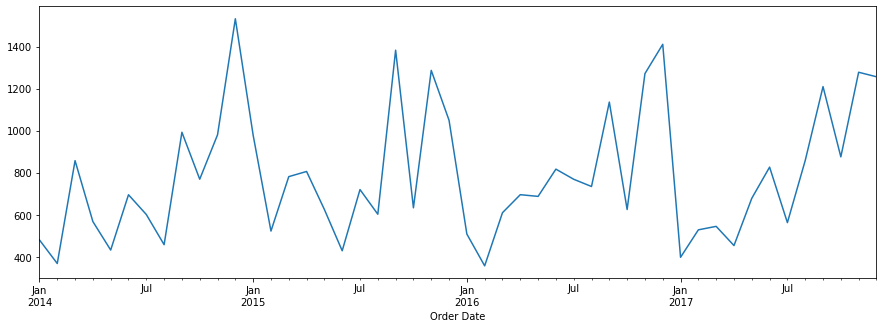

In [52]:
# Independence Tests -> Profit was dependent on DISCOUNT and SALES 
# Univariate variable for TSA -> make sure that it's an independent variable
# We preferred SALES over PROFIT 
# For BULK data -> always do an independence test 
# Profit = y = f(Sales, Discount) <- Profit was dependent 
# Sales -> y = f(order_items ) 
plt.figure()
y.plot(figsize=(15,5))
plt.show()


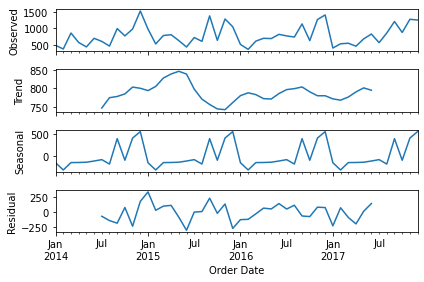

In [53]:
# Eigenvectors and EigenValues -> 
# Vectors on which any linear transformation is applied -> and doesn't change its direction
# SUCH a vector is called Eigenvector, and its value is Eigenvalue 
# https://www.mathsisfun.com/algebra/eigenvalue.html 

# OLD Algo for TS: https://orangematter.solarwinds.com/2019/12/15/holt-winters-forecasting-simplified/
# SEASONS could impact your data 
# EXTERNAL factors -> Marketing or promotion or discounts that could manipulate your predictions

# SARIMAX -> SEASONAL ARIMA EXTREME 
# SEASONS -> PERIODS or PATTERNS that repeat w.r.t. TIME 
# TREND -> whether the overall data was increasing or decreasing (slope, dy/dx )
# RESIDUE or NOISE -> Whatever is left 
# INSTEAD of making prediction on original data 
# We decompose the GRAPH into Seasons, TRENDS, RESIDUE 
# each of them is predicted separately, and then composed to get final prediction 
# AR I MA -> Auto-Regression, Integrated seasons, Moving Averages 
# we will apply all 3 algorithms to SEASONS (season present or season absent), trend, residue
# 
# MOVING AVERAGES
#time windows keep on shifting , so that history has slowly LESSER impact on future
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

fig = decomposition.plot()
plt.show() 
# INITIAL 5 points are IGNORED so that trend calculation can be done
# TREND needs a history! 
# 3 and 5 are your magic numbers 
# THESE ARE WINDOWS of time periods 

2 algorithms to build these truth tables:

1) EXHAUSTIVE -> ALL COMBINATIONS (entire truth table will be created)

- SLOWER

-> GRID SEARCH 

2) Not the best, but workable answer (randomly truth will be created)

- FASTER 

-> RANDOM SEARCH 

https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d


Can be used to find best combination(s) of algo comparison, parameters, hyperparameters, metrics or wherever TOO many are present and we could select a few of them! 

In [55]:
# in AR I MA -> p,d,q 
p = d = q = range(0,2) # VALUE generators between [0,1] 
pdq = list(itertools.product(p,d,q))
print(pdq)



[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [59]:
# SEASONS -> manipulated manually -> at what point should I expect repeatation?
# YEARs -> our repeatation is ANNUAL in nature 
seasons = 12 # my data granularity is monthly -> so to take 1 year as a SEASON, i have to take
# 12 months 
# LIST COMPREHENSION -> (0,0,0) -> (0,0,0,12)
seasonal_pdq = [   (x[0],x[1],x[2], seasons)  for x in pdq] # if x was (0,1,0), -> (0,1,0,12)
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[0]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[1]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[2]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[3]))
# here is an INDIVIDUAL MODEL -> WITH and WITHOUT SEASON 
# ALL SUCH PERMUTATIONS WILL BE EXHAUSTIVELY CREATED!!! 
# EVERY POSSIBLE COMBINATION HAS BEEN CREATED! 
# AN SARIMAX -> SEASONAL ARIMA EXHAUSTIVE 
# ALL possible algos with (seasonal_pdq) and without season (pdq)
# 

SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 1, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 1, 12)


In [65]:
# HOW DO WE DECIDE IF ONE MODEL IS BETTER THAN THE OTHER MODEL?
# METRICS -> ACCURACY, PRecision, Recall, F1 score, MAE, MSE....
# AKAIKE INFORMATION CRITERION (for a while now, this is a PROBABILISTIC formula to calculate
# error in liklihood/probability calculation)
# AIC = 2k - 2 ln (L) 
# L -> maximum Liklihood of the model's correctness (same formula as in RMSE,STD 
# etc, but converted into Probaility of correctness rather than actual number)
# k -> no. of samples being considered 
# for AIC, MINIMUM value is preferred 
# AIC is LOSS CALCULATION -> hence more loss = bad model
# 
# we will end up with a LOT of IMPOSSIBLE/Imaginary/Complex/Divby0/Errors models
# LOT of these models may not even make sense, and will throw exceptions!
# EXCEPTION handling is MUST  
min_pdq = (999,999,999)
min_spdq = (999,999,999,12)
min_AIC = 999
for param in pdq:
  for sparam in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=sparam, enforce_stationarity=False)
      predictions = model.fit()
      print('Model={}X{}. AIC= {}'.format(param, sparam, predictions.aic))
      if(predictions.aic < min_AIC):
        min_pdq = param
        min_spdq = sparam
        min_AIC = predictions.aic
    except Exception as e:
      print(e)
      continue

print('**** Smallest PDQ,SPDQ is *****')
print(min_AIC)
print(min_pdq)
print(min_spdq)

# Somebody said, that because sky is blue, you remain ANGRY
# the only way to prove or disprove this
# be angry in presence of blue sky, and in its absence
# EXHAUSTIVE comparison! angry, no angry -> when sky is BLUE, GREEN, PINK 
# and at the same time in ABSENCE of sky also -> to calculate if there was any impact of 
# sky at all! 


Model=(0, 0, 0)X(0, 0, 0, 12). AIC= 769.0817523205916
Model=(0, 0, 0)X(0, 0, 1, 12). AIC= 548.1766779886199
Model=(0, 0, 0)X(0, 1, 0, 12). AIC= 477.71701309202774
maxlag should be < nobs
Model=(0, 0, 0)X(1, 0, 0, 12). AIC= 497.2314433418337
Model=(0, 0, 0)X(1, 0, 1, 12). AIC= 478.3653805779411
Model=(0, 0, 0)X(1, 1, 0, 12). AIC= 318.0047199116341
maxlag should be < nobs
Model=(0, 0, 1)X(0, 0, 0, 12). AIC= 720.9252270739973
Model=(0, 0, 1)X(0, 0, 1, 12). AIC= 514.7587049639892
Model=(0, 0, 1)X(0, 1, 0, 12). AIC= 466.5556513479083
maxlag should be < nobs
Model=(0, 0, 1)X(1, 0, 0, 12). AIC= 498.8314925544705
Model=(0, 0, 1)X(1, 0, 1, 12). AIC= 467.10392112800224
Model=(0, 0, 1)X(1, 1, 0, 12). AIC= 319.9884876946219
maxlag should be < nobs
Model=(0, 1, 0)X(0, 0, 0, 12). AIC= 677.894766859465
Model=(0, 1, 0)X(0, 0, 1, 12). AIC= 488.70123262205084
Model=(0, 1, 0)X(0, 1, 0, 12). AIC= 486.63785671879367
maxlag should be < nobs
Model=(0, 1, 0)X(1, 0, 0, 12). AIC= 497.78896630044073
Model=(0, 1,

In [69]:
model = sm.tsa.statespace.SARIMAX(y, order=min_pdq, seasonal_order= min_spdq, enforce_stationarity=False)
# (0, 1, 0)X(1, 0, 1, 12)
model2 = sm.tsa.statespace.SARIMAX(y, order=(0, 1, 0), seasonal_order= (1, 0, 1, 12), enforce_stationarity=False)
results = model.fit()
results2 = model2.fit()
# we've taken 2 models so that we can compare their predictions 
results.summary() #.tables[1]  # AIC => needs to be lowest 
# results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -145.301
Date:                            Wed, 22 Apr 2020   AIC                            298.602
Time:                                    10:07:35   BIC                            302.966
Sample:                                01-01-2014   HQIC                           299.630
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1280      0.276      0.464      0.643      -0.412       0.669
ma.L1         -0.9998      0.450     -2.223      0.026      -1.881      -0.118
ar.S.L12      -0.2811      0.154     -1.826      0.068      -0.583       0.021
sigma2      3.028e+04   1.49e-05   2.04e+09      0.000    3.03e+04    3.03e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.77
Prob(Q):                               nan   Prob(JB):                         0.68
Heteroskedasticity (H):               0.67   Skew:                            -0.22
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.73e+24. Standard errors may be unstable.
"""

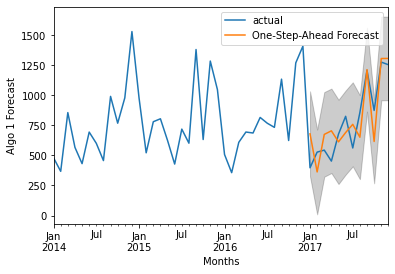

In [73]:
# let's check the actual predictions and plot them 

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred2 = results2.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred2_ci = pred2.conf_int()
ax = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred.predicted_mean.plot(ax=ax, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
ax.set_xlabel('Months')
ax.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show() 



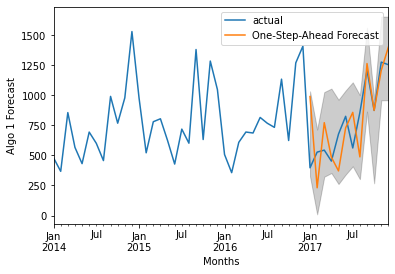

In [74]:
plt.figure()
bx = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred2.predicted_mean.plot(ax=bx, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
bx.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
bx.set_xlabel('Months')
bx.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show() 

In [63]:
abc = ['hello', 'world', 'xyz']
nums = range(10)
xya = [ (num/2, num%2 ) for num in nums ]
xya


#    ['hello', 'world'] X ['bye', 'bye', 'world']
# hello X [bye, bye , world] , world X ['bye', 'bye', 'world']

[(0.0, 0),
 (0.5, 1),
 (1.0, 0),
 (1.5, 1),
 (2.0, 0),
 (2.5, 1),
 (3.0, 0),
 (3.5, 1),
 (4.0, 0),
 (4.5, 1)]

In [0]:
# When we are building truth tables, while calculating loss on it, 
# we can end up with div by 0 situations and other exceptions also

# DERIVATES and PARTIAL DERIVATIVES 
# https://www.mathsisfun.com/calculus/derivatives-introduction.html 
# https://www.mathsisfun.com/calculus/derivatives-partial.html 

